In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Loop through directories and files in '/kaggle/input', but do not print filenames
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        # Now 'file_path' contains the path to each file
    

In [2]:
import tensorflow as tf
import tensorboard
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import random
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
RANDOM_SEED = 123

2024-05-03 11:53:31.071716: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 11:53:31.071866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 11:53:31.278706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [21]:
def load_data(dir_path, IMG_SIZE):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):  # Using os.path.join for better path concatenation
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))  # Using os.path.join for better path concatenation
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

TRAIN_DIR = '/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/train'
TEST_DIR = '/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test'

IMG_SIZE = (48, 48)

X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)


100%|██████████| 7/7 [01:45<00:00, 15.14s/it]


32298 images loaded from /kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/train directory.


In [22]:
X_train

array([[[[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.65882355, 0.65882355, 0.65882355],
         [0.5882353 , 0.5882353 , 0.5882353 ],
         [0.5137255 , 0.5137255 , 0.5137255 ]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.5529412 , 0.5529412 , 0.5529412 ],
         [0.49411765, 0.49411765, 0.49411765],
         [0.41568628, 0.41568628, 0.41568628]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00784314, 0.00784314, 0.00784314],
         [0.        , 0.        , 0.        ],
         ...,
         [0.47058824, 0.47058824, 0.47058824],
         [0.3882353 , 0.3882353 , 0.3882353 ],
         [0.37254903, 0.37254903, 0.37254903]],

        ...,

        [[0.56078434, 0.56078434, 0.56078434],
         [0.58431375, 0.58431375, 0.58431375]

In [23]:
def plot_samples(X, y, labels_dict, n=50):
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0], cmap='gray')  # Display grayscale images

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        

In [24]:
def contrast_stretching(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_min = np.min(img)
    img_max = np.max(img)
    img_stretched = (img - img_min) * (255.0 / (img_max - img_min))
    return img_stretched.astype(np.uint8)

In [28]:
def unsharp_mask_more_sharp(img, kernel_size=(5, 5), sigma=1.0, amount=1.5, threshold=0):
    blurred_img = cv2.GaussianBlur(img, kernel_size, sigma)
    sharp_img = cv2.addWeighted(img, 1 + amount, blurred_img, -amount, 0)
    sharp_img = np.clip(sharp_img, 0, 255)
    return sharp_img.astype(np.uint8)

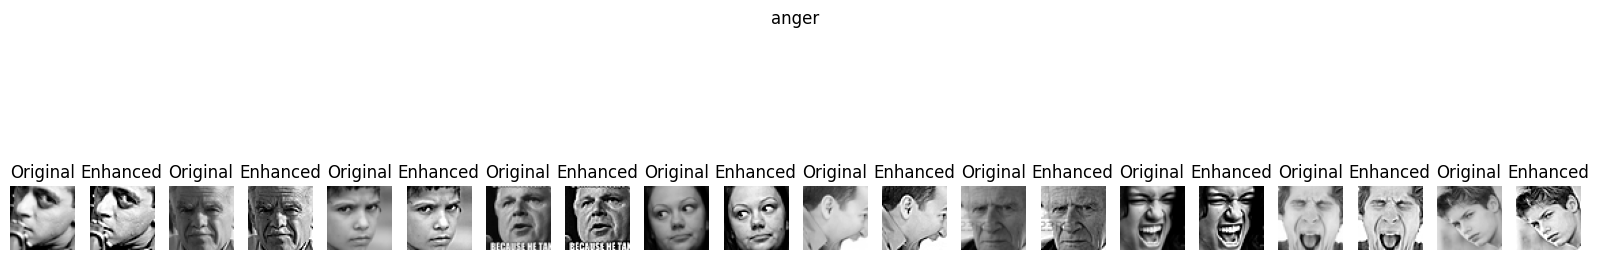

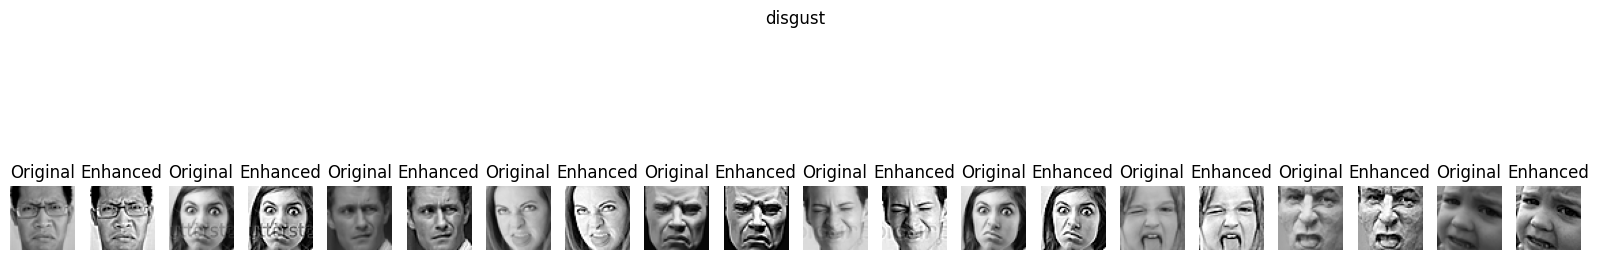

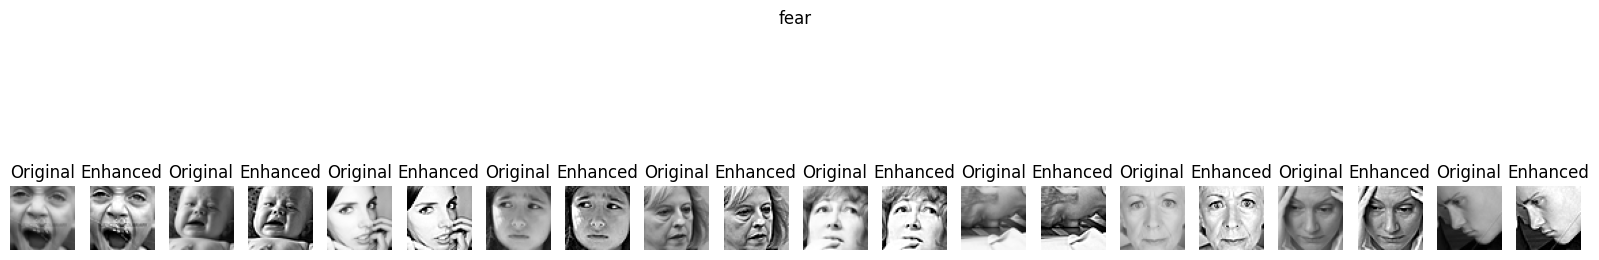

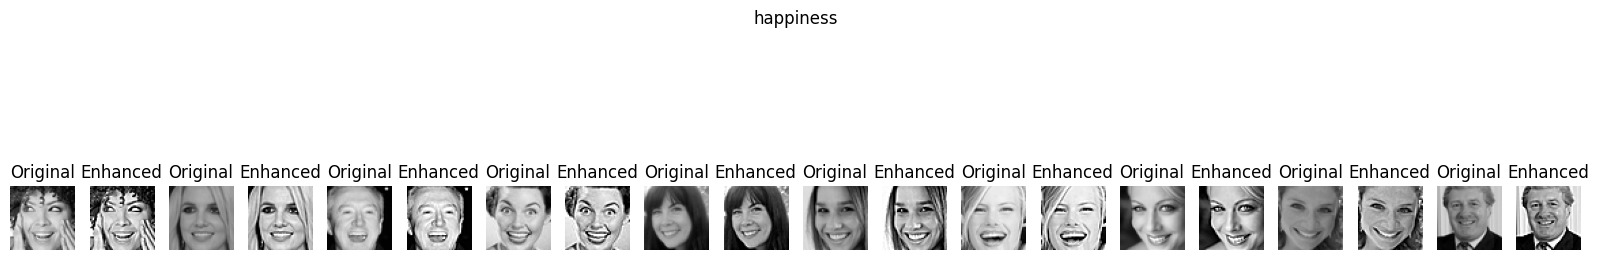

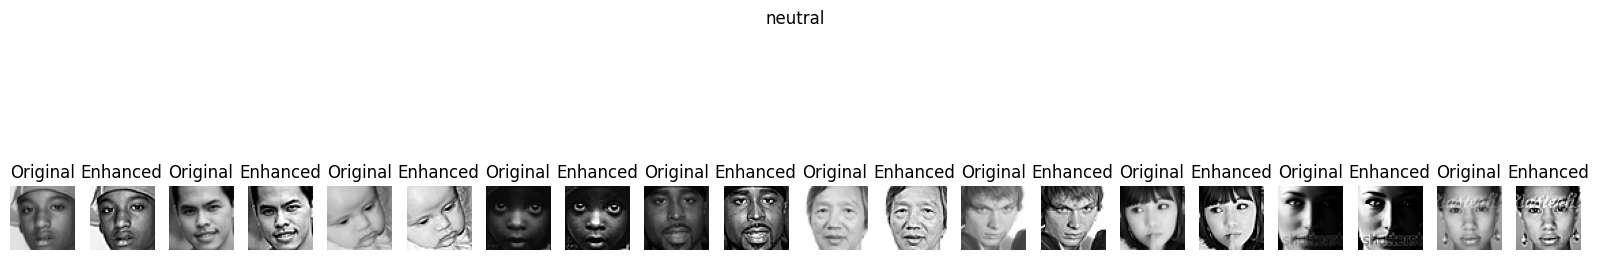

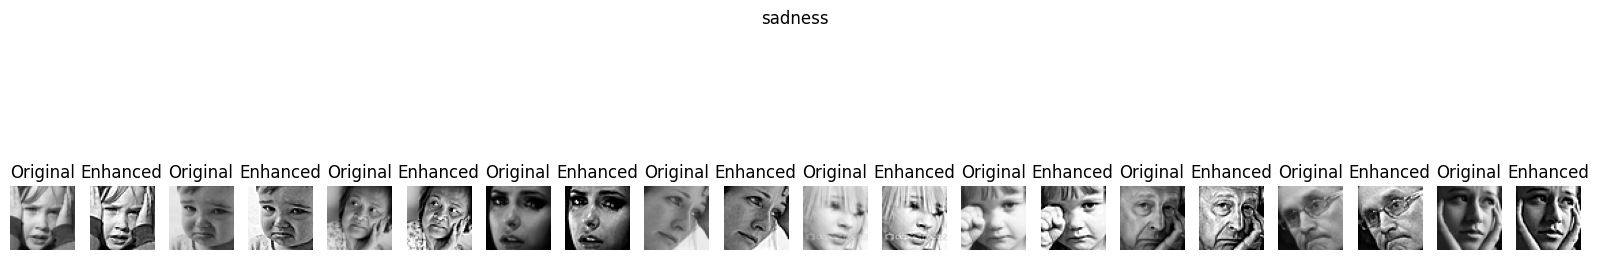

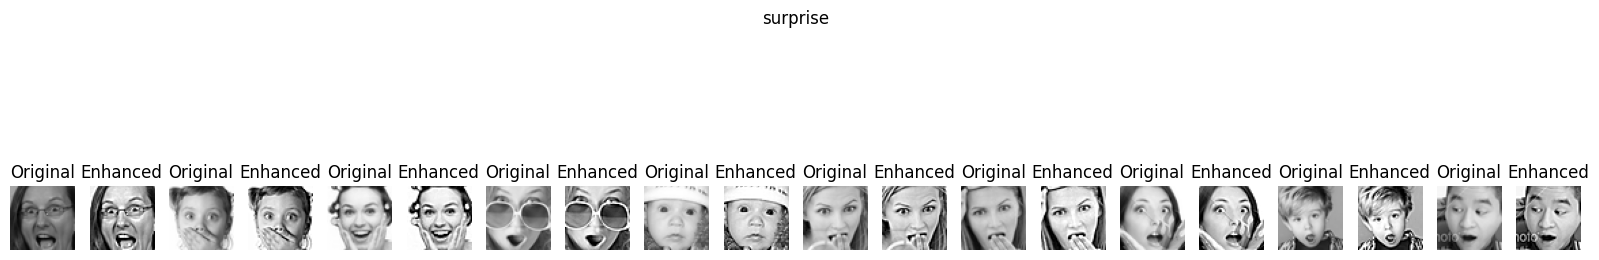

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples_with_enhancement(X, y, labels_dict, n=10):
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index).flatten()]
        num_imgs = min(n, len(imgs))  # Limit the number of images to the minimum of n and the number of available images

        # Adjust the figsize to make each subplot smaller
        plt.figure(figsize=(16, 4))  # Adjust the width and height for smaller subplots
        for img_idx in range(num_imgs):
            img = imgs[img_idx]
            original_img = img.copy()  # Make a copy of the original image

            # Assume contrast_stretching and unsharp_mask are defined elsewhere
            enhanced_img = contrast_stretching(original_img)
            enhanced_img = unsharp_mask_more_sharp(enhanced_img)

            # Plot the original image
            plt.subplot(1, num_imgs * 2, 2 * img_idx + 1)
            plt.imshow(original_img, cmap='gray')
            plt.title('Original')
            plt.axis('off')

            # Plot the enhanced image
            plt.subplot(1, num_imgs * 2, 2 * img_idx + 2)
            plt.imshow(enhanced_img, cmap='gray')
            plt.title('Enhanced')
            plt.axis('off')

        plt.suptitle(labels_dict[index])
        plt.tight_layout()  # Adjust layout to minimize overlap
        plt.show()

# Call the function with X_train, y_train, and train_labels
plot_samples_with_enhancement(X_train, y_train, train_labels)



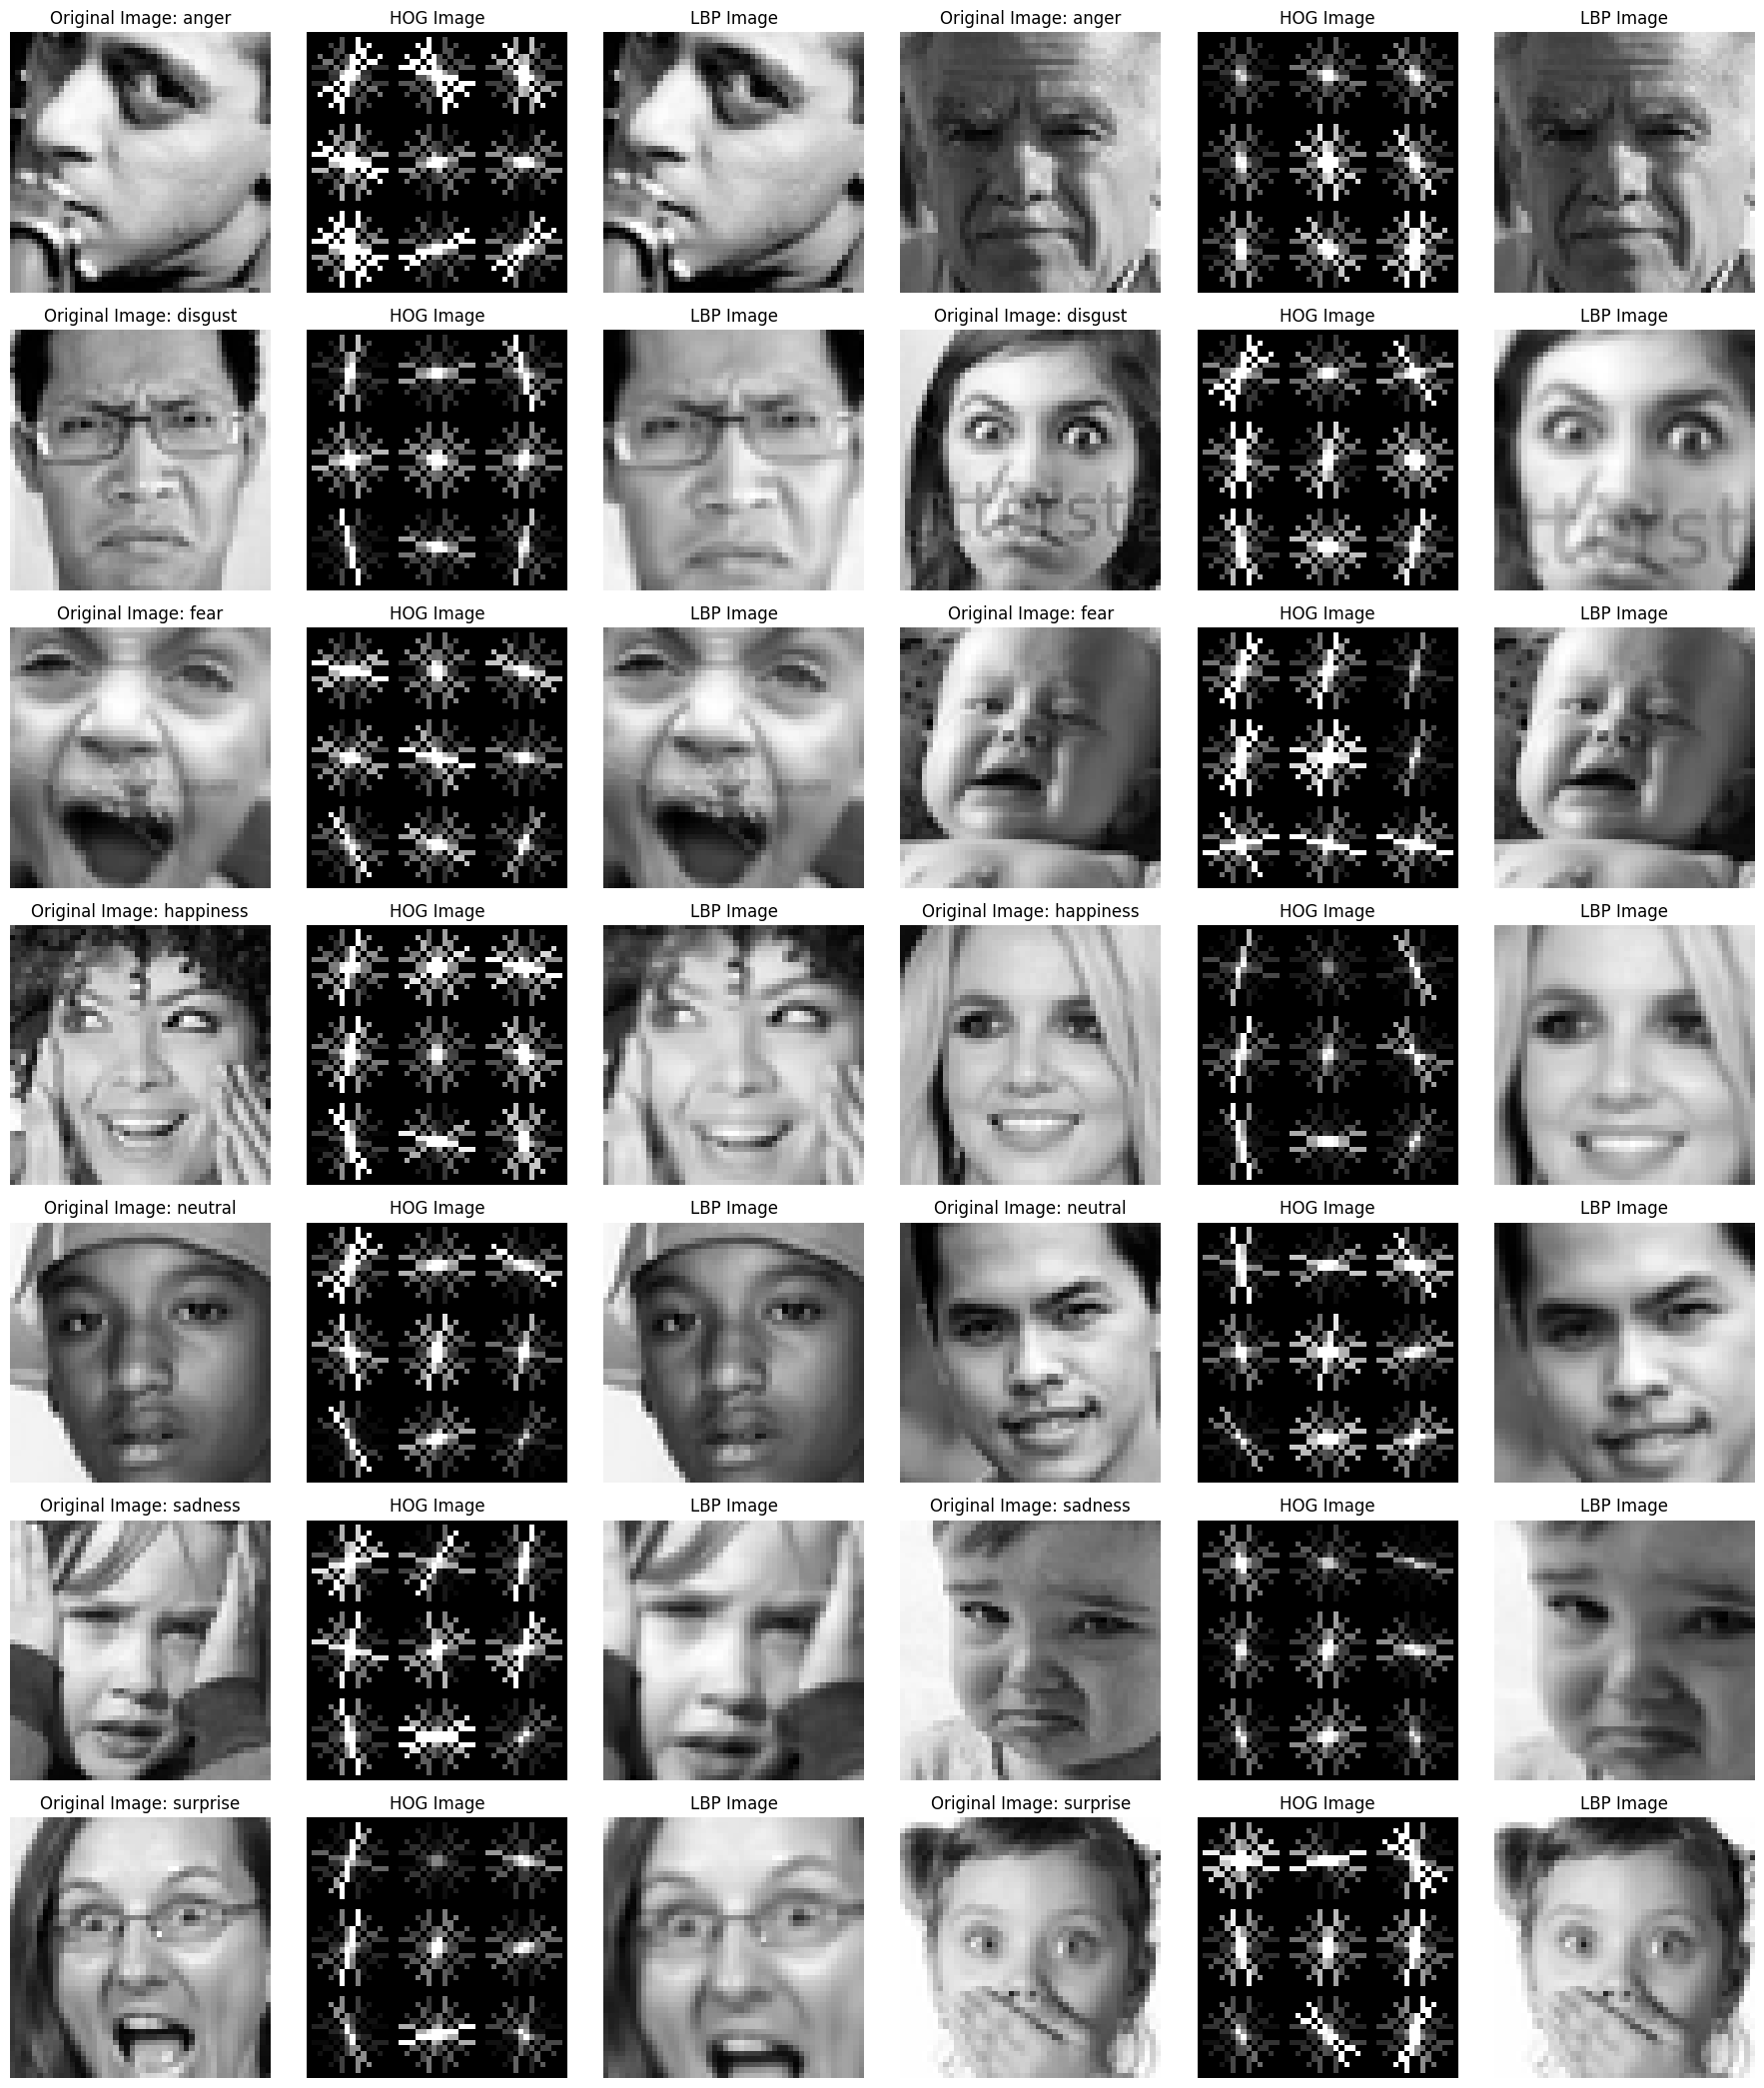

In [68]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from skimage import exposure

# Define the path to the dataset
dataset_path = '/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/train'

# Define the classes
classes = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

# Function to extract Local Binary Pattern (LBP) features from an image
def extract_lbp_features(image, radius=3, n_points=8 * 3):
    # Compute the LBP representation of the image
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    # Calculate the histogram of LBP representation
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize the histogram
    return hist

# Function to preprocess images and extract features
def preprocess_and_extract_features(X):
    features = []  # List to store extracted features
    hog_images = []  # List to store HOG visualizations
    lbp_images = []  # List to store LBP visualizations
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Iterate through each image path
    for img_path in X:
        img = cv2.imread(img_path)  # Read the image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)  # Detect faces in the image
        
        # If no face is detected, use the whole image
        if len(faces) == 0:
            face_img = gray
        else:
            x, y, w, h = faces[0]
            face_img = gray[y:y+h, x:x+w]  # Extract the face region
            face_img = cv2.resize(face_img, (48, 48))  # Resize to a fixed size
        
        # Extract HOG features and visualize
        hog_feat, hog_image = hog(face_img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
        # Extract LBP features
        lbp_hist = extract_lbp_features(face_img)
        
        features.append(np.hstack([hog_feat, lbp_hist]))  # Combine HOG and LBP features
        hog_images.append(hog_image)  # Append HOG visualization
        lbp_images.append(face_img)  # Append LBP visualization
        
    return np.array(features), hog_images, lbp_images

# Function to load image paths for selected classes
def load_images():
    images_paths = []  # List to store image paths
    for cls in classes:
        class_path = os.path.join(dataset_path, cls)  # Path for each class
        class_images = [os.path.join(class_path, img) for img in os.listdir(class_path)[:2]]  # Get first two images for each class
        images_paths.extend(class_images)  # Append image paths
    return images_paths

# Load selected images paths
selected_images_paths = load_images()

# Extract features and images for visualization
features, hog_images, lbp_images = preprocess_and_extract_features(selected_images_paths)

# Function to plot images
def plot_features_transform(images_paths, hog_images, lbp_images, num_classes=7):
    fig, ax = plt.subplots(num_classes, 6, figsize=(18, num_classes * 3))  # Create subplots
    for i in range(num_classes):
        for j in range(2):  # Two images per class
            img_idx = i * 2 + j
            original_image = cv2.imread(images_paths[img_idx])
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
            
            ax[i, j*3].imshow(original_image, cmap='gray')  # Plot original image
            ax[i, j*3].set_title(f'Original Image: {images_paths[img_idx].split("/")[-2]}')  # Set title
            ax[i, j*3].axis('off')  # Turn off axis
            
            hog_image_rescaled = exposure.rescale_intensity(hog_images[img_idx], in_range=(0, 10))
            ax[i, j*3+1].imshow(hog_image_rescaled, cmap='gray')  # Plot HOG visualization
            ax[i, j*3+1].set_title('HOG Image')  # Set title
            ax[i, j*3+1].axis('off')  # Turn off axis
            
            ax[i, j*3+2].imshow(lbp_images[img_idx], cmap='gray')  # Plot LBP visualization
            ax[i, j*3+2].set_title('LBP Image')  # Set title
            ax[i, j*3+2].axis('off')  # Turn off axis
    plt.tight_layout()  # Adjust layout
    plt.show()  # Show plot

# Call the plotting function
plot_features_transform(selected_images_paths, hog_images, lbp_images)


Found 32298 images belonging to 7 classes.
Epoch 1/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 65s 62ms/step - accuracy: 0.2605 - loss: 1.7933
Epoch 2/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms/step - accuracy: 0.4288 - loss: 1.4774
Epoch 3/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 81s 61ms/step - accuracy: 0.4971 - loss: 1.3131
Epoch 4/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 84s 63ms/step - accuracy: 0.5276 - loss: 1.2286
Epoch 5/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 63s 62ms/step - accuracy: 0.5561 - loss: 1.1682
Epoch 6/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 63s 62ms/step - accuracy: 0.5775 - loss: 1.1064
Epoch 7/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 81s 61ms/step - accuracy: 0.5994 - loss: 1.0648
Epoch 8/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 62s 61ms/step - accuracy: 0.6192 - loss: 1.0173
Epoch 9/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 63s 62ms/step - accuracy: 0.6315 - loss: 0.9745
Epoch 10/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 81s 61ms/step - accuracy: 0.6489 - loss: 0.9333
Epoch 11/20
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms/step

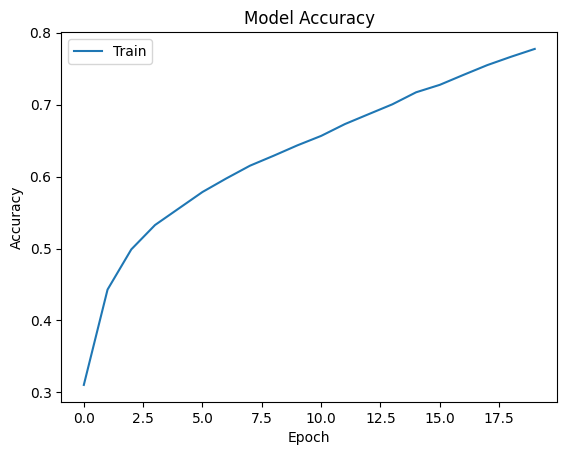

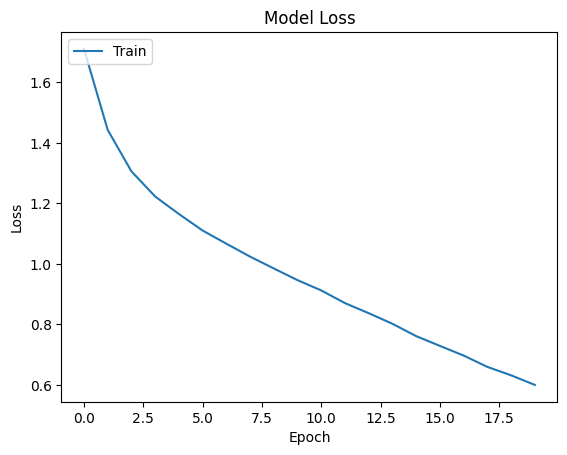

In [119]:
import matplotlib.pyplot as plt

# Define a CNN model
def create_cnn_model(input_shape, num_classes):
    # Define a sequential model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # Convolutional layer with 32 filters and ReLU activation
        MaxPooling2D((2, 2)),  # Max pooling layer
        Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters and ReLU activation
        MaxPooling2D((2, 2)),  # Max pooling layer
        Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters and ReLU activation
        MaxPooling2D((2, 2)),  # Max pooling layer
        Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters and ReLU activation
        Flatten(),  # Flatten layer to convert 2D output to 1D
        Dense(64, activation='relu'),  # Dense layer with 64 units and ReLU activation
        Dense(num_classes, activation='softmax')  # Output layer with softmax activation
    ])
    return model

# Create the CNN model
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255)  # Data generator for training images with rescaling
train_generator = train_datagen.flow_from_directory(
    dataset_path,  # Path to the dataset
    target_size=(48, 48),  # Target size of input images
    batch_size=32,  # Batch size
    class_mode='categorical'  # Class mode for categorical classification
)

# Train the model
history = model.fit(
    train_generator,  # Training data generator
    epochs=20,  # Number of epochs
)

# Plot training accuracy
plt.plot(history.history['accuracy'])  # Plot training accuracy
plt.title('Model Accuracy')  # Set title
plt.xlabel('Epoch')  # Set x-axis label
plt.ylabel('Accuracy')  # Set y-axis label
plt.legend(['Train'], loc='upper left')  # Add legend
plt.show()  # Show plot

# Plot training loss
plt.plot(history.history['loss'])  # Plot training loss
plt.title('Model Loss')  # Set title
plt.xlabel('Epoch')  # Set x-axis label
plt.ylabel('Loss')  # Set y-axis label
plt.legend(['Train'], loc='upper left')  # Add legend
plt.show()  # Show plot


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


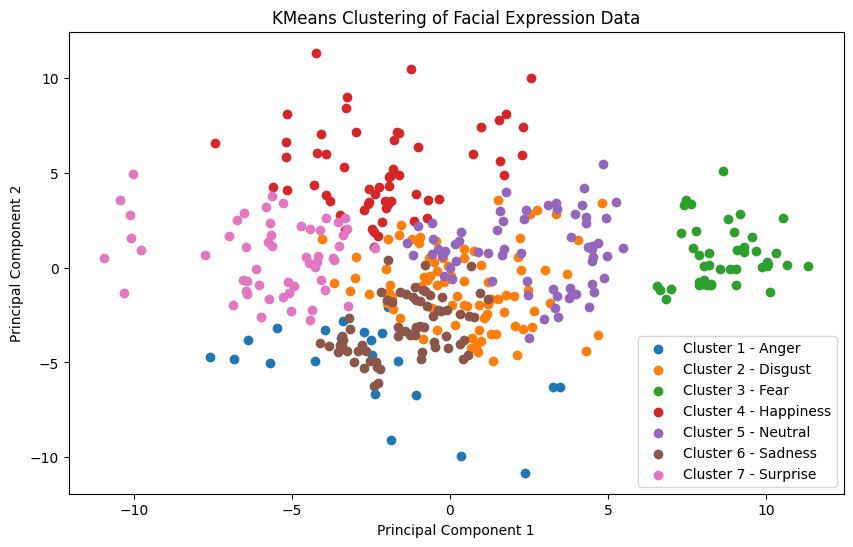

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_olivetti_faces

# Load facial expression data (Olivetti Faces dataset)
faces_data = fetch_olivetti_faces()
X = faces_data.data  # Features (images)
y = faces_data.target  # Target labels (identity of the individuals)++

# Reduce dimensionality with PCA (Principal Component Analysis)
pca = PCA(n_components=50)  # Reduce dimensionality to 50 principal components
X_pca = pca.fit_transform(X)  # Apply PCA to the data

# Choose the number of clusters (you may need to adjust this based on your data)
n_clusters = 7  # Number of clusters (facial expression categories)

# Initialize KMeans clustering algorithm
kmeans = KMeans(n_clusters=n_clusters, random_state=42)  # Initialize KMeans with the specified number of clusters

# Fit KMeans to the PCA-transformed data
kmeans.fit(X_pca)  # Fit KMeans to the reduced-dimensionality data

# Get cluster labels assigned by KMeans
cluster_labels = kmeans.labels_  # Extract cluster labels assigned by KMeans

# Define labels for clusters (corresponding to facial expressions)
cluster_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Visualize clusters (using only the first two principal components for simplicity)
plt.figure(figsize=(10, 6))  # Set figure size
for i in range(n_clusters):
    plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i+1} - {cluster_names[i]}')
    # Scatter plot of data points belonging to each cluster
plt.title('KMeans Clustering of Facial Expression Data')  # Set title
plt.xlabel('Principal Component 1')  # Set x-axis label
plt.ylabel('Principal Component 2')  # Set y-axis label
plt.legend()  # Add legend
plt.show()  # Show plot
+++++=+_